Cross Matching EPIC Using Magnitudes
-------------------------------------

This notebook shows a way to crossmatch a catalogue of sources against EPIC using magnitudes. This is a multiple step stage of finding

* **positive** cross matches (where the nearest source has reasonably consistent magnitude) then finding 
* **uncertain** cross matches (where there is a nearby source that has reasonably consistent magnitude)
* **negative** cross matches (where there are no nearby sources that have consistent magnitudes).

To find negative cross matches a threshold must be input by the user, beyond which no source is considered near or close enough in magnitude. 

There are a few reasons why the EPIC catalogue may not have a match. 

* The catalogue is incomplete, and so no source can be found
* The catalogue is built on magnitudes from multiple surveys, including with JHK photometry. This is not comprable to Kp mag in some cases.

In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
%matplotlib inline

In [2]:
hard_distance_threshold=5*u.arcsecond
hard_magnitude_threshold=5
distance_threshold=2*u.arcsecond
magnitude_threshold=1.

This catalogue (from K2SC) contains a list of sources with RAs, Decs and fluxes. (We'll create a Kp magnitude for each of them and zeropoint it against the EPIC catalogue.)

In [3]:
h=fits.open('C02_master_merged.fits')
mag=25-2.5*np.log10(h[1].data['Total_flux'])
RA,Dec=h[1].data['RA']*u.radian,h[1].data['DEC']*u.radian
RA,Dec=RA.to(u.deg),Dec.to(u.deg)

#Ensure all targets are unique
unq=np.unique(RA*Dec,return_index=True)[1]
RA,Dec,mag=RA[unq],Dec[unq],mag[unq]

We'll read in the whole EPIC catalog into memory. This is a large catalogue and there's potentially a quicker way to do this. We'll trim down to just C2 so that we don't have to search the whole catalog.

In [4]:
import pickle
targlist=pickle.load(open('xmatch.p','rb'))

As a first pass we find the **nearest** RAs and Decs of the sources to those in the EPIC catalogue.

In [5]:
EPICcatalog=SkyCoord(targlist.k2_ra*u.deg,targlist.k2_dec*u.deg)

In [6]:
INPUTcatalog = SkyCoord(ra=RA, dec=Dec)

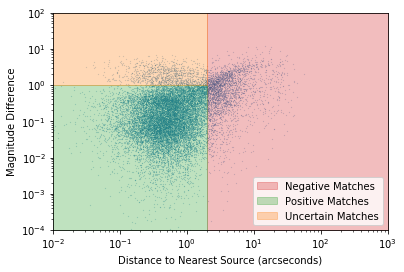

In [7]:
n=1

idx, d2d, d3d = INPUTcatalog.match_to_catalog_sky(EPICcatalog,nthneighbor=n)  
gri=np.where(np.asarray(targlist.kepflag)[idx]=='gri')[0]
if n==1:
    zeropoint=np.median(np.asarray(targlist.kp)[idx][gri]-mag[gri])
#Plot
#------------------------#
plt.figure()
plt.scatter(d2d.to(u.arcsec),np.abs(np.asarray(targlist.kp)[idx]-(mag+zeropoint)),s=0.01)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0001,100)
plt.xlim(0.01,1000)
plt.xlabel('Distance to Nearest Source (arcseconds)')
plt.ylabel('Magnitude Difference')
plt.fill_between([distance_threshold.value,1E3],1E-4,1E2,color='C3',alpha=0.3,label='Negative Matches')
plt.fill_between([1E-2,distance_threshold.value],1E-4,magnitude_threshold,color='C2',alpha=0.3,label='Positive Matches')
plt.fill_between([1E-2,distance_threshold.value],magnitude_threshold,1E2,color='C1',alpha=0.3,label='Uncertain Matches')
plt.legend()
#------------------------#


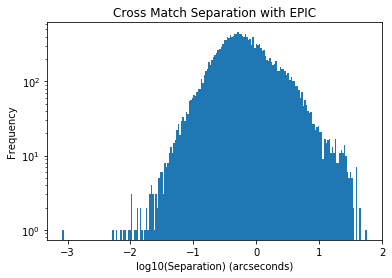

In [19]:
fig,ax=plt.subplots()
_=ax.hist(np.log10(d2d.to(u.arcsec).value),200)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('log10(Separation) (arcseconds)')
plt.title('Cross Match Separation with EPIC')
plt.savefig('images/crossmatch.png',dpi=150,bbox_inches='tight')

In [16]:
idx, d2d, d3d = INPUTcatalog.match_to_catalog_sky(EPICcatalog)  

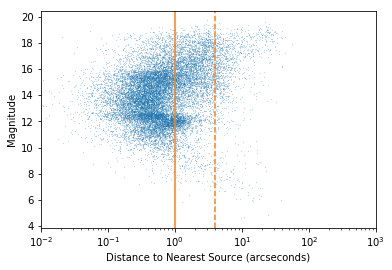

In [18]:
plt.scatter(d2d.to(u.arcsec),np.abs((mag+zeropoint)),s=0.01)
plt.xscale('log')
plt.xlim(0.01,1000)
plt.ylabel('Magnitude')
plt.xlabel('Distance to Nearest Source (arcseconds)')
plt.axvline(1,c='C1')
plt.axvline(4,c='C1',ls='--')

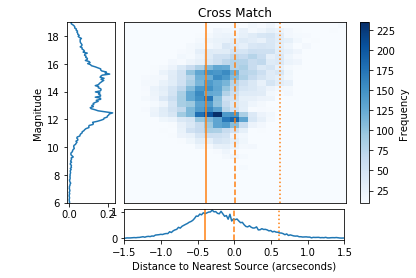

In [83]:
from matplotlib.colors import LogNorm
fig=plt.figure()
ax=plt.subplot2grid((6,6),(0,1),colspan=5,rowspan=5)
_=plt.hist2d(np.log10(d2d.to(u.arcsec).value),np.abs((mag+zeropoint)), bins=40,cmap=plt.get_cmap('Blues'),vmin=10)
cbar=plt.colorbar()
cbar.set_label('Frequency')
plt.ylim(6,19)
plt.xlim(-1.5,1.5)
plt.xticks([])
plt.yticks([])
plt.title("Cross Match")

plt.axvline(np.log10(0.4),c='C1')
plt.axvline(np.log10(1),c='C1',ls='--')
plt.axvline(np.log10(4),c='C1',ls=':')



ax=plt.subplot2grid((6,6),(5,1),colspan=4)
h=np.histogram(np.log10(d2d.to(u.arcsec).value),200,normed=True)
x=(np.arange(len(h[0])))*(np.median(h[1][1:]-h[1][0:-1]))+h[1][0]

plt.plot(x,h[0])
plt.xlim(-1.5,1.5)
plt.xlabel('Distance to Nearest Source (arcseconds)')

plt.axvline(np.log10(0.4),c='C1')
plt.axvline(np.log10(1),c='C1',ls='--')
plt.axvline(np.log10(4),c='C1',ls=':')




ax=plt.subplot2grid((6,6),(0,0),rowspan=5)
plt.ylim(6,19)
h=np.histogram(np.abs((mag+zeropoint)),200,normed=True)
x=(np.arange(len(h[0])))*(np.median(h[1][1:]-h[1][0:-1]))+h[1][0]
plt.plot(h[0],x)
plt.ylabel('Magnitude')


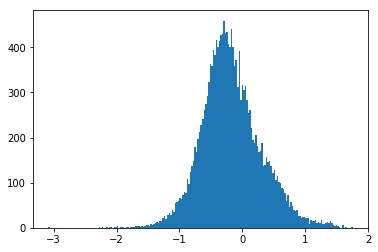

In [20]:
fig,ax=plt.subplots()
_=ax.hist(np.log10(d2d.to(u.arcsec).value),200)

In [99]:
hard_distance_threshold=5*u.arcsecond
hard_magnitude_threshold=5
distance_threshold=1.2*u.arcsecond
magnitude_threshold=1.

In [100]:
results=pd.DataFrame(columns=['RA','Dec','InputMag',
                              'EPICKpMag_1','EPICd2d_1','MatchID_1','KepFlag_1',
                              'EPICKpMag_2','EPICd2d_2','MatchID_2','KepFlag_2',
                              'EPICKpMag_3','EPICd2d_3','MatchID_3','KepFlag_3',
                              'EPICKpMag_4','EPICd2d_4','MatchID_4','KepFlag_4',
                              'EPICKpMag_5','EPICd2d_5','MatchID_5','KepFlag_5',
                              'EPICKpMag_6','EPICd2d_6','MatchID_6','KepFlag_6',
                             'Nth_Neighbour','Xflag','EPICID','KpMag'])
results['RA']=RA
results['Dec']=Dec
results['InputMag']=mag
results['Nth_Neighbour']=0
results['Xflag']=-1

In [101]:
for n in np.arange(6)+1:
    idx, d2d, d3d = INPUTcatalog.match_to_catalog_sky(EPICcatalog,nthneighbor=n)  
    gri=np.where(np.asarray(targlist.kepflag)[idx]=='gri')[0]
    if n==1:
        zeropoint=np.median(np.asarray(targlist.kp)[idx][gri]-mag[gri])

    nkeys=results.keys()[4*n-1:3+4*n]
    ar=np.transpose([targlist.kp[idx]-(mag+zeropoint),d2d.to(u.arcsecond).value,targlist.id[idx],targlist.kepflag[idx]])
    out=ar[:,1]>=hard_distance_threshold.value
    ar[out,:]=np.nan
    results[nkeys]=ar
    

In [102]:
results.loc[np.where(np.isfinite(results['EPICd2d_1'])==False)[0],'Xflag']=0


pos=np.where((results['EPICd2d_1']<=distance_threshold)&(np.abs(results['EPICKpMag_1'])<=magnitude_threshold))[0]
results.loc[pos,'Xflag']=2
results.loc[pos,'Nth_Neighbour']=1



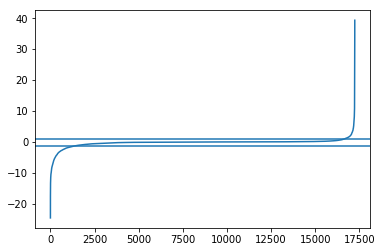

In [103]:
plt.plot(np.sort(results.EPICd2d_1*results.EPICKpMag_1))
pos=(results.Xflag==2)
x1=np.min(results.EPICd2d_1[pos]*results.EPICKpMag_1[pos])
x2=np.max(results.EPICd2d_1[pos]*results.EPICKpMag_1[pos])

plt.axhline(x1)
plt.axhline(x2)

In [104]:
met=np.transpose([results.EPICd2d_1*results.EPICKpMag_1,
     results.EPICd2d_2*results.EPICKpMag_2,
     results.EPICd2d_3*results.EPICKpMag_3,
     results.EPICd2d_4*results.EPICKpMag_4,
     results.EPICd2d_5*results.EPICKpMag_5,
     results.EPICd2d_6*results.EPICKpMag_6])

In [105]:
for i,m,f in zip(xrange(len(results)),met,results.Xflag):
    if f!=-1:
        continue
    x=np.arange(len(m))
    x=x[np.where(np.isfinite(m))]
    x=np.argmin(m[x])
    if (m[x]>=x1)&(m[x]<=x2):
        results.loc[i,'Nth_Neighbour']=x+1
        results.loc[i,'Xflag']=1
    else:
        results.loc[i,'Nth_Neighbour']=x+1
        results.loc[i,'Xflag']=0
    

In [106]:
for i,n,f in zip(xrange(len(results)),results.Nth_Neighbour,results.Xflag):
    if f!=0:
        continue
    if results.loc[i]['Nth_Neighbour'.format(n)]==0:
        continue
    if results.loc[i]['KepFlag_{}'.format(n)]=='gri':
        continue
    if (results.loc[i]['EPICKpMag_{}'.format(n)]<=hard_magnitude_threshold) and (results.loc[i]['EPICd2d_{}'.format(n)]<=distance_threshold.value):
        results.loc[i]['Xflag']=1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [107]:
for f in np.unique(results.Xflag):
    print f,len(results[results.Xflag==f])

0 2804
1 2820
2 12397


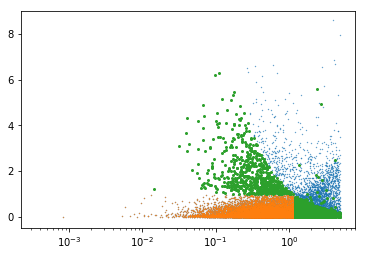

In [108]:
plt.scatter(results.EPICd2d_1,np.abs(results.EPICKpMag_1),s=0.1)
plt.scatter(results.EPICd2d_1[results.Xflag==2],np.abs(results.EPICKpMag_1[results.Xflag==2]),s=0.1)
plt.scatter(results.EPICd2d_1[results.Xflag==1],np.abs(results.EPICKpMag_1[results.Xflag==1]),s=4)


plt.xscale('log')

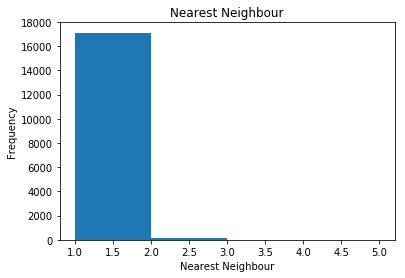

In [109]:
_=plt.hist(results.Nth_Neighbour,[1,2,3,4,5])
plt.title('Nearest Neighbour')
plt.ylabel('Frequency')
plt.xlabel('Nearest Neighbour')